In [1]:
import numpy as np
import pandas as pd

In [2]:
import operator

from copy import copy

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
df_train = pd.read_csv("../data/train.txt", sep='\t', header=None, names=["users", "items", "rank"])
df_train.head()

,users,items,rank
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [6]:
df_train["rank"].unique()

array([5, 3, 4, 1, 2])

In [7]:
n_users = df_train["users"].max()
n_items = df_train["items"].max()

In [8]:
df_train[["users", "items"]] -= 1
df_train.head()

,users,items,rank
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,3
4,0,4,3


In [9]:
def iter_step(weights, bias, df_grouped, C, alpha):
    weights_, bias_ = copy(weights), copy(bias)
    
    for user, group in df_grouped["users"]:
        index = group["items"].values
        
        Q = weights_["items"][index]
        Q = np.hstack((np.ones(shape=(len(index), 1), dtype=float), Q))
        r = group["rank"].values - bias_["items"][index]
        G = np.diag(1.0 + alpha * r)
        
        A = np.dot(Q.T, np.dot(G, Q)) + C * np.eye(Q.shape[1])
        b = np.dot(Q.T, np.dot(G, r))
        
        solution = np.linalg.solve(A, b)
        weights_["users"][user], bias_["users"][user] = solution[1:], solution[0] 
    
    for item, group in df_grouped["items"]:
        index = group["users"].values
        
        P = weights_["users"][index]
        P = np.hstack((np.ones(shape=(len(index), 1), dtype=float), P))
        r = group["rank"].values - bias_["users"][index]
        G = np.diag(1.0 + alpha * r)
        
        A = np.dot(P.T, np.dot(G, P)) + C * np.eye(P.shape[1])
        b = np.dot(P.T, np.dot(G, r))
        
        solution = np.linalg.solve(A, b)
        weights_["items"][item], bias_["items"][item] = solution[1:], solution[0]
        
    return weights_, bias_

In [10]:
df_grouped = {cat : df_train.groupby(by=cat) for cat in ["users", "items"]}

In [11]:
df_test = pd.read_csv("../data/test.txt", sep='\t', header=None, names=["users", "items"])
df_test.head()

,users,items
0,1,20
1,1,33
2,1,61
3,1,117
4,1,155


In [12]:
df_test[["users", "items"]] -= 1
df_test.head()

,users,items
0,0,19
1,0,32
2,0,60
3,0,116
4,0,154


In [13]:
def score(matrix, values):
    y_pred = [matrix[user, item] for user, item, rank in values]
    y_true = map(operator.itemgetter(2), values)
    return mean_squared_error(y_true, y_pred)

In [14]:
def score_predict(matrix, values, i):
    pred = np.clip([matrix[user, item] for user, item in values], a_min=1, a_max=5)
    submission = pd.DataFrame(list(enumerate(pred)), columns=["Id", "Mark"])
    submission["Id"] += 1
    submission.to_csv("./submissions/submission_{:02}.csv".format(i), index=False)

In [15]:
C = 5.0
n_features = 4
alpha = 0.14

In [16]:
weights = dict()
weights["users"] = np.random.normal(loc=0.0, scale=0.01, size=(n_users, n_features))
weights["items"] = np.random.normal(loc=0.0, scale=0.01, size=(n_items, n_features))

bias = dict()
bias["users"] = np.random.normal(loc=0.0, scale=0.01, size=(n_users, ))
bias["items"] = np.random.normal(loc=0.0, scale=0.01, size=(n_items, ))

In [17]:
scores = []

In [18]:
n_iters = 100

for i in range(n_iters):
    weigths, bias = iter_step(weights, bias, C, alpha)
    matrix = bias["users"].reshape(-1, 1) + bias["items"].reshape(1, -1) \
            + np.dot(weights["users"], weights["items"].T)
    scores.append(score(matrix, df_train.values))
    score_predict(matrix, df_test.values, i + 1)
    print "\r{} of {} iters passed...".format(i + 1, n_iters),

100 of 100 iters passed...


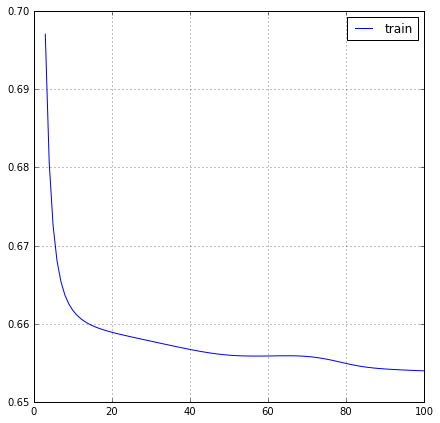

In [19]:
offset = 2

plt.figure(figsize=(7, 7))
plt.plot(range(offset+1, len(scores)+1), scores[offset:], label="train")
plt.legend()
plt.grid()

In [20]:
np.argsort(scores)

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 56, 57,
       55, 58, 54, 59, 67, 53, 60, 61, 66, 52, 62, 65, 63, 64, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])